# Regressão Logística

In [59]:
library(dplyr)
library(ggplot2)
library(plyr)
library(scales)

In [3]:
data = read.table("dataset/enade.txt",sep=";", dec = ",", header = TRUE)
head(data)

,NU_ANO,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_GRUPO,CO_CURSO,CO_MODALIDADE,CO_MUNIC_CURSO,CO_UF_CURSO,CO_REGIAO_CURSO,...,QE_I59,QE_I60,QE_I61,QE_I62,QE_I63,QE_I64,QE_I65,QE_I66,QE_I67,QE_I68
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,2018,1356,10003,10020,1,47116,1,3546603,35,3,...,6,6,6,6,6,6,6,6,6,5
2,2018,1356,10003,10020,1,47116,1,3546603,35,3,...,6,6,6,6,6,6,6,6,6,6
3,2018,1356,10003,10020,1,47116,1,3546603,35,3,...,6,6,6,6,6,6,6,6,6,5
4,2018,1356,10003,10020,1,47116,1,3546603,35,3,...,6,6,6,6,5,6,6,6,6,4
5,2018,1356,10003,10020,1,47116,1,3546603,35,3,...,6,6,6,6,6,6,6,6,6,6
6,2018,1356,10003,10020,1,47116,1,3546603,35,3,...,6,5,6,6,6,6,6,6,6,5


In [4]:
df = data[data$CO_GRUPO == 13,]

In [5]:
dim(df)

[1] 9582  137

In [8]:
dim(df[df$TP_PRES==222,])

[1] 1497  137

## Variáveis de IES

In [28]:
df_1 = df %>% 
        select(TP_PRES, TP_SEXO, NU_IDADE,QE_I08,QE_I10,QE_I23, CO_TURNO_GRADUACAO) %>% 
        setNames(c("presenca","genero", "idade", "renda", "trabalho", "esforco",
                  "turno"))

In [29]:
df_1$presenca = ifelse(df_1$presenca == 222,'ausente','presente')

In [30]:
table(df_1$presenca)


 ausente presente 
    1497     8085 

In [31]:
df_1$renda = mapvalues(df_1$renda, from=c("A","B","C","D","E","F","G"), to=c("Até 1.5 salário mínimo","De 1.5 a 3 salários mínimos",
                                                                "De 3 a 4.5 salários mínimos","De 4.5 a 6 salários mínimos","De 6 a 10 salários mínimos",
                                                                                "10 a 30 salários mínimos", "Acima de 30 salários mínimos"))
df_1$trabalho = mapvalues(df_1$trabalho, from=c("A","B","C","D","E"), to=c("Não trabalha",
                                                                  "Trabalha eventualmente",
                                                                 "Trabalha até 20 hrs. semanais",
                                                                 "Trabalha de 21 a 39 hrs. semanais",
                                                                 "Trabalha 40 hrs. semanais ou mais"))
df_1$esforco = mapvalues(df_1$esforco, from=c("A","B","C","D","E"), to=c("Nenhuma, apenas assistindo as aulas","De uma a três",
                                                                "De quatro a sete","De oito adoze","Mais de doze"))
df_1$turno = mapvalues(df_1$turno, from=c(1,2,3,4), to=c("matutino","vespetino",
                                                                "integral","noturno"))

In [32]:
head(df_1)

,presenca,genero,idade,renda,trabalho,esforco,turno
,<chr>,<fct>,<int>,<fct>,<fct>,<fct>,<chr>
161,presente,F,28,De 3 a 4.5 salários mínimos,Trabalha 40 hrs. semanais ou mais,De quatro a sete,noturno
162,presente,M,30,De 4.5 a 6 salários mínimos,Trabalha 40 hrs. semanais ou mais,De uma a três,noturno
163,presente,M,29,De 3 a 4.5 salários mínimos,Trabalha 40 hrs. semanais ou mais,De quatro a sete,noturno
164,presente,F,22,De 1.5 a 3 salários mínimos,Trabalha 40 hrs. semanais ou mais,De uma a três,noturno
165,presente,M,47,De 1.5 a 3 salários mínimos,Trabalha 40 hrs. semanais ou mais,De quatro a sete,noturno
166,presente,M,27,De 3 a 4.5 salários mínimos,Trabalha 40 hrs. semanais ou mais,De quatro a sete,noturno


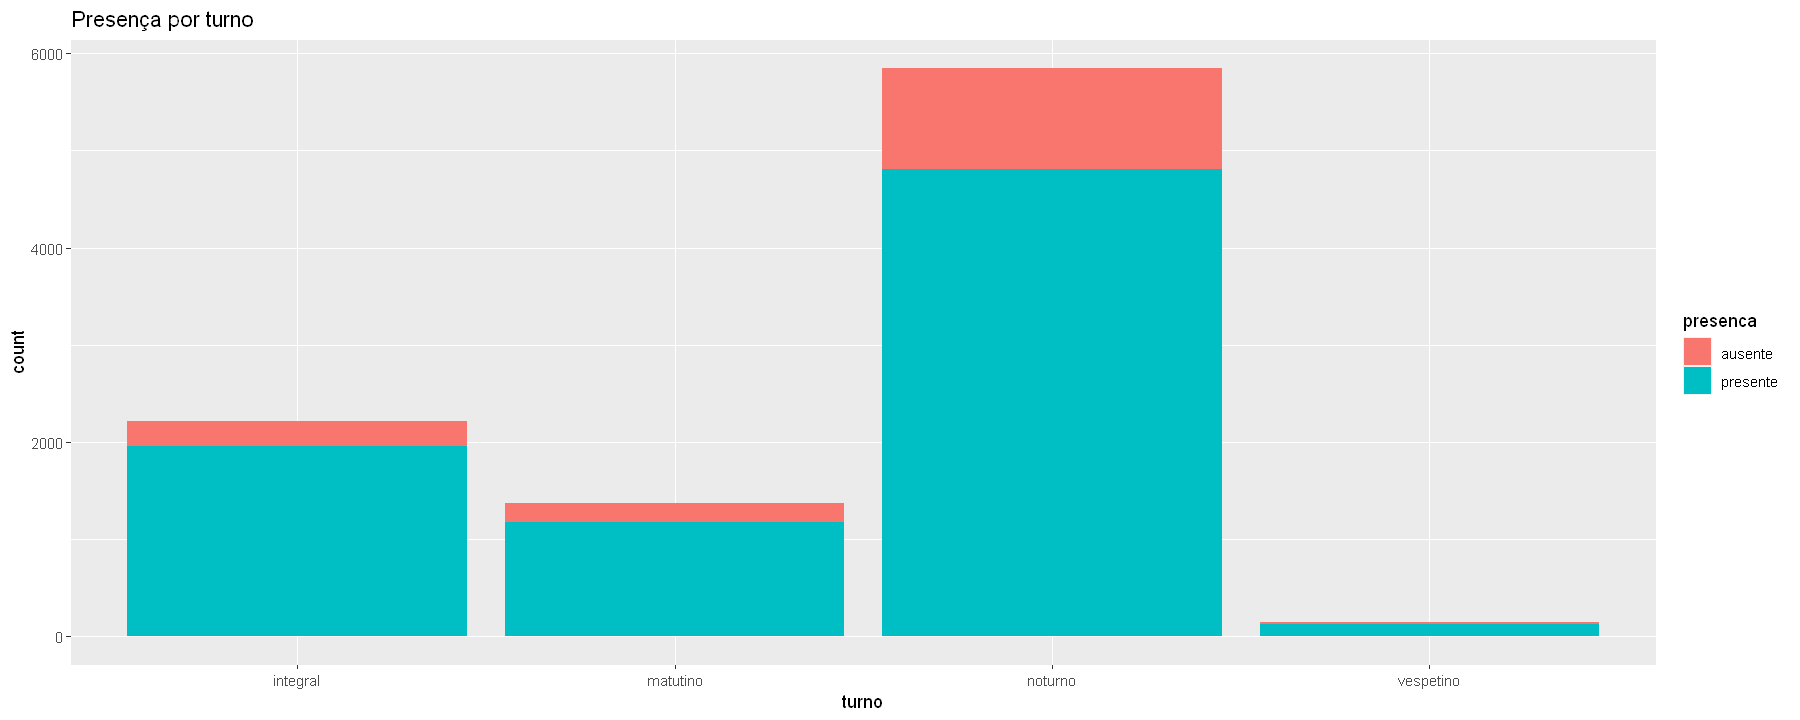

In [56]:
ggplot(df_1, aes(x=turno, fill=presenca)) +
       geom_bar() +
       #geom_text() +
       labs(title="Presença por turno")

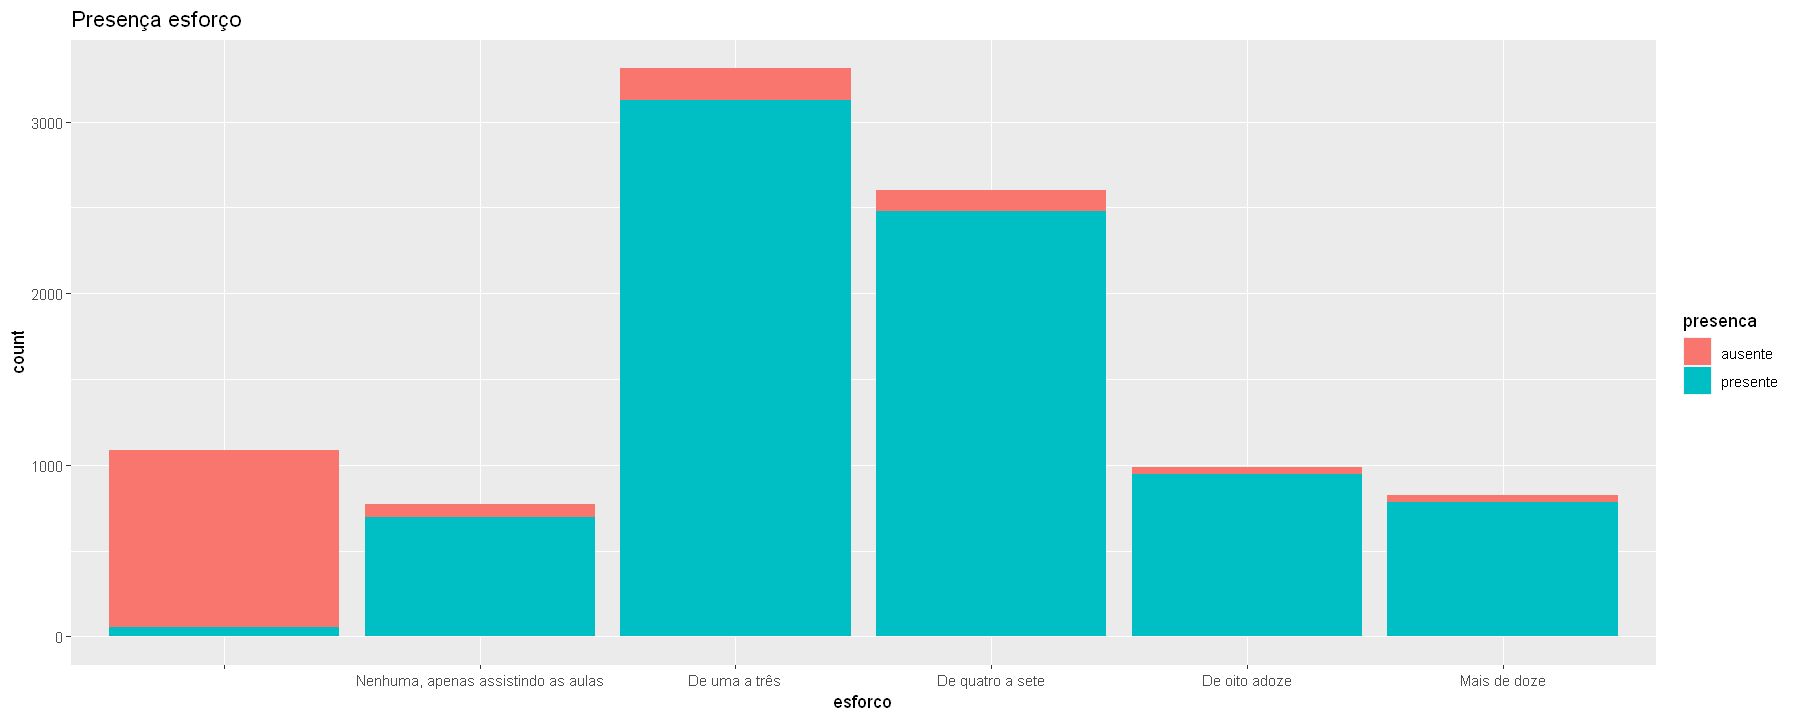

In [58]:
ggplot(df_1, aes(x=esforco, fill=presenca)) +
       geom_bar() +
       #geom_text() +
       labs(title="Presença esforço")

In [70]:
table(df_1$esforco)


                                    Nenhuma, apenas assistindo as aulas 
                               1087                                 770 
                      De uma a três                    De quatro a sete 
                               3311                                2600 
                      De oito adoze                        Mais de doze 
                                989                                 825 

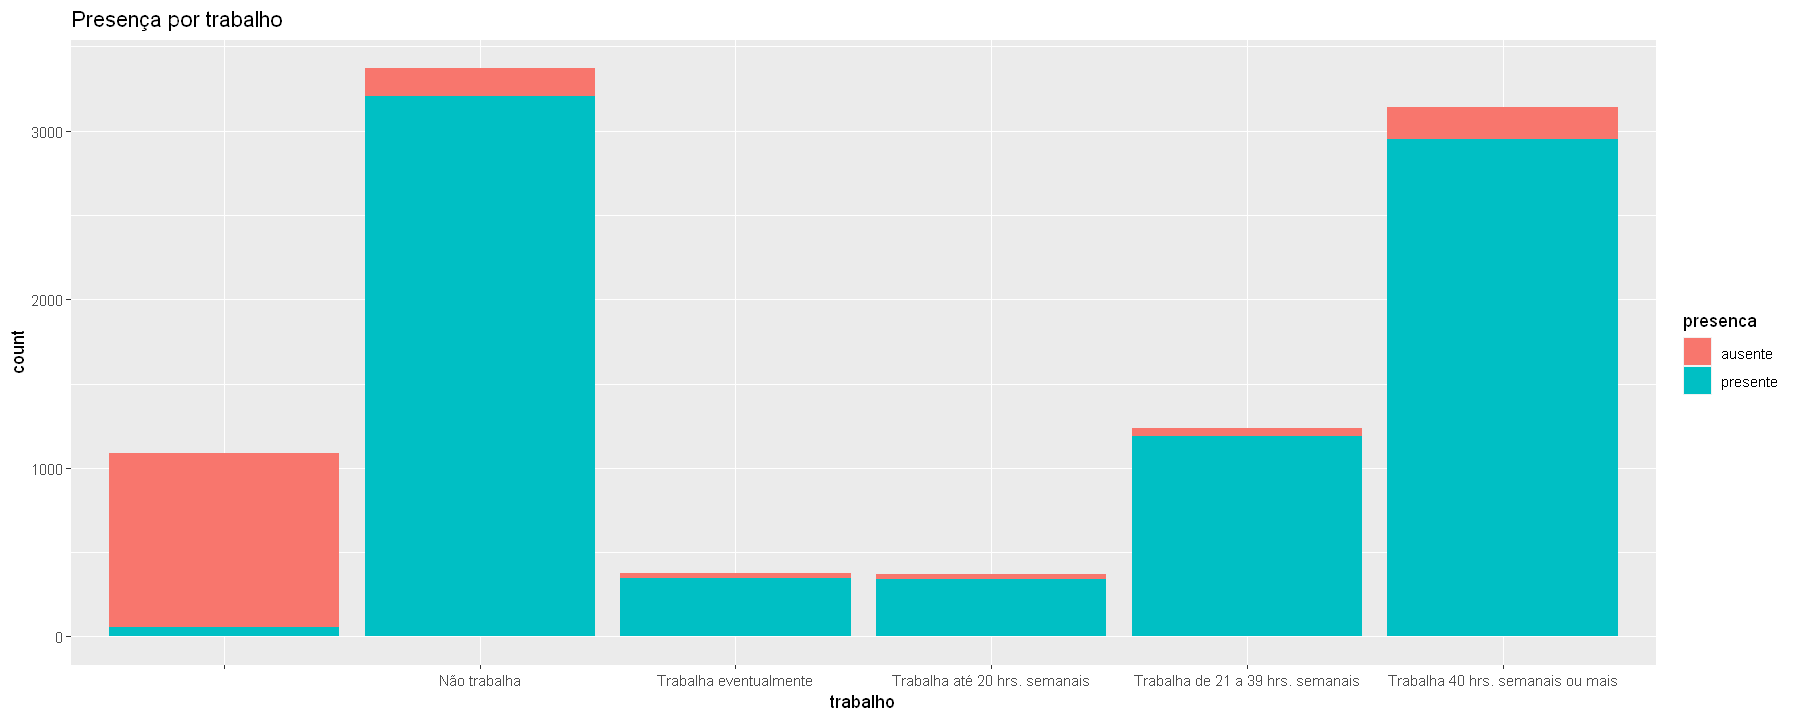

In [57]:
options(repr.plot.width = 15, repr.plot.height = 6)
ggplot(df_1, aes(x=trabalho, fill=presenca)) +
       geom_bar() +
       #geom_text() +
       labs(title="Presença por trabalho")

In [69]:
table(df_1$trabalho)


                                                       Não trabalha 
                             1087                              3370 
           Trabalha eventualmente     Trabalha até 20 hrs. semanais 
                              377                               371 
Trabalha de 21 a 39 hrs. semanais Trabalha 40 hrs. semanais ou mais 
                             1235                              3142 

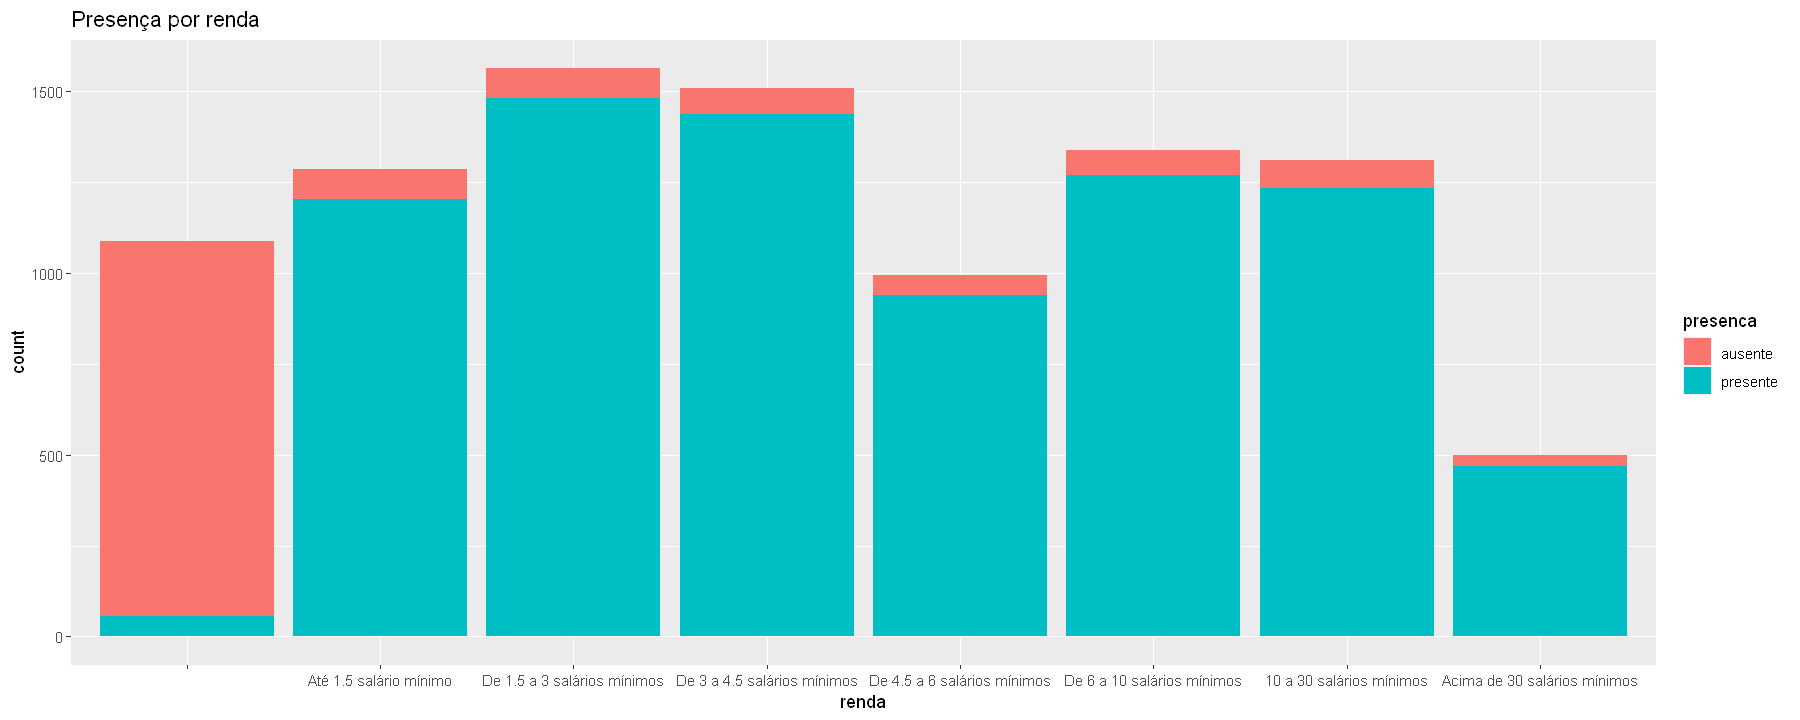

In [50]:
options(repr.plot.width = 15, repr.plot.height = 6)
ggplot(df_1, aes(x=renda, fill=presenca)) +
       geom_bar() +
       #geom_text() +
       labs(title="Presença por renda")

In [67]:
table(df_1$renda)


                                   Até 1.5 salário mínimo 
                        1087                         1286 
 De 1.5 a 3 salários mínimos  De 3 a 4.5 salários mínimos 
                        1562                         1508 
 De 4.5 a 6 salários mínimos   De 6 a 10 salários mínimos 
                         993                         1338 
    10 a 30 salários mínimos Acima de 30 salários mínimos 
                        1309                          499 

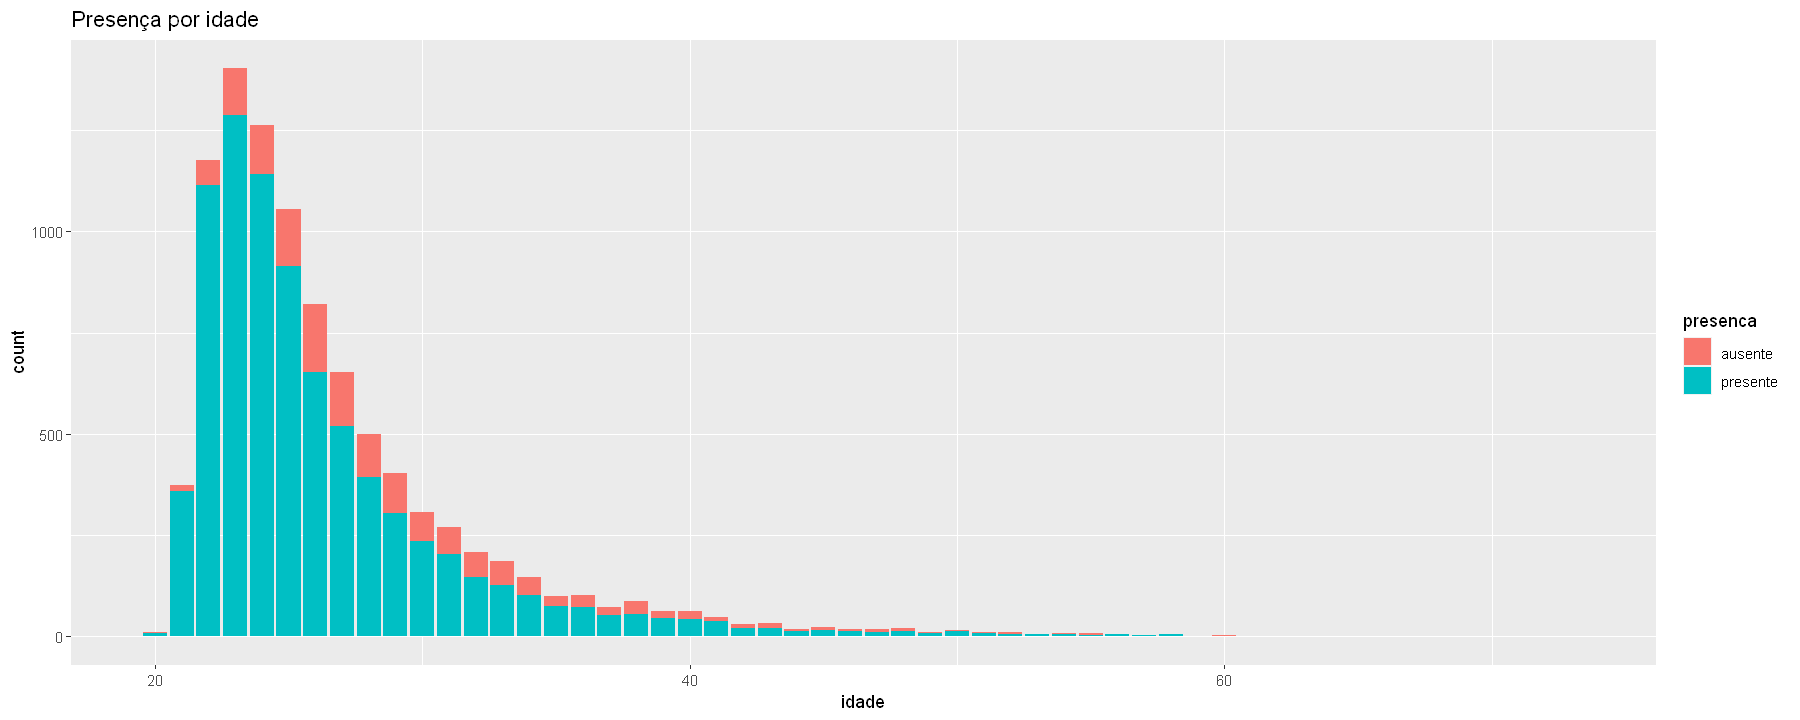

In [66]:
options(repr.plot.width = 15, repr.plot.height = 6)
ggplot(df_1, aes(x=idade, fill=presenca), width=0.8) +
       geom_bar() +
       #geom_text() +
       labs(title="Presença por idade")

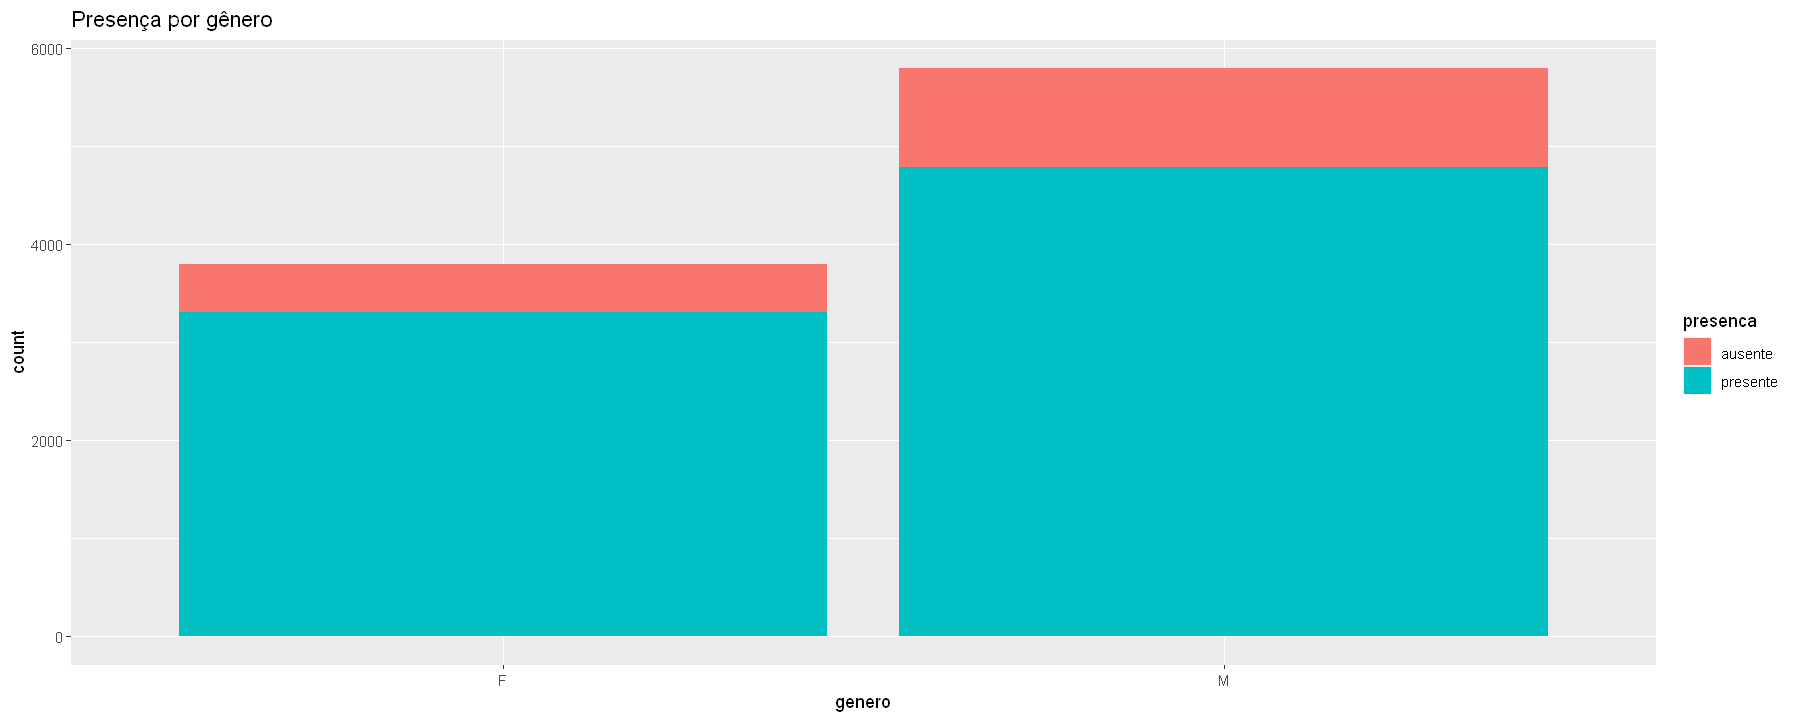

In [64]:
ggplot(df_1, aes(x=genero, fill=presenca)) +
       geom_bar() +
       #geom_text() +
       labs(title="Presença por gênero")

In [77]:
df_1$presenca = as.factor(df_1$presenca)
df_1$turno = as.factor(df_1$turno)

In [71]:
sapply(df_1, function(x) sum(is.na(x)))

presenca   genero    idade    renda trabalho  esforco    turno 
       0        0        0        0        0        0        0

In [74]:
table(df_1$presenca)


 ausente presente 
    1497     8085 

In [72]:
head(df_1)

,presenca,genero,idade,renda,trabalho,esforco,turno
,<chr>,<fct>,<int>,<fct>,<fct>,<fct>,<chr>
161,presente,F,28,De 3 a 4.5 salários mínimos,Trabalha 40 hrs. semanais ou mais,De quatro a sete,noturno
162,presente,M,30,De 4.5 a 6 salários mínimos,Trabalha 40 hrs. semanais ou mais,De uma a três,noturno
163,presente,M,29,De 3 a 4.5 salários mínimos,Trabalha 40 hrs. semanais ou mais,De quatro a sete,noturno
164,presente,F,22,De 1.5 a 3 salários mínimos,Trabalha 40 hrs. semanais ou mais,De uma a três,noturno
165,presente,M,47,De 1.5 a 3 salários mínimos,Trabalha 40 hrs. semanais ou mais,De quatro a sete,noturno
166,presente,M,27,De 3 a 4.5 salários mínimos,Trabalha 40 hrs. semanais ou mais,De quatro a sete,noturno


# Modelo 1

In [81]:
model_1 = glm(presenca~., data=df_1, family=binomial(link='logit'))

In [82]:
summary(model_1)


Call:
glm(formula = presenca ~ ., family = binomial(link = "logit"), 
    data = df_1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6740   0.2687   0.3049   0.3496   2.6899  

Coefficients: (2 not defined because of singularities)
                                            Estimate Std. Error z value
(Intercept)                                -1.888516   0.270095  -6.992
generoM                                    -0.094092   0.096325  -0.977
idade                                      -0.030721   0.007445  -4.126
rendaAté 1.5 salário mínimo                 5.578815   0.262786  21.229
rendaDe 1.5 a 3 salários mínimos            5.665661   0.245474  23.081
rendaDe 3 a 4.5 salários mínimos            5.779918   0.247974  23.309
rendaDe 4.5 a 6 salários mínimos            5.616515   0.258295  21.745
rendaDe 6 a 10 salários mínimos             5.683208   0.247185  22.992
renda10 a 30 salários mínimos               5.525103   0.245189  22.534
rendaAcima de 30 salár

In [83]:
exp(model_1$coefficients)

(Intercept) 
                                 0.1512962 
                                   generoM 
                                 0.9101989 
                                     idade 
                                 0.9697458 
               rendaAté 1.5 salário mínimo 
                               264.7577883 
          rendaDe 1.5 a 3 salários mínimos 
                               288.7788676 
          rendaDe 3 a 4.5 salários mínimos 
                               323.7326149 
          rendaDe 4.5 a 6 salários mínimos 
                               274.9296101 
           rendaDe 6 a 10 salários mínimos 
                               293.8907143 
             renda10 a 30 salários mínimos 
                               250.9120688 
         rendaAcima de 30 salários mínimos 
                               220.1633445 
                      trabalhoNão trabalha 
                                 1.2077909 
            trabalhoTrabalha eventualmente 
                                 0.6351721 
     trabalhoTrabalha até 20 hrs. semanais 
                                 0.7326792 
 trabalhoTrabalha de 21 a 39 hrs. semanais 
                                 1.4807816 
 trabalhoTrabalha 40 hrs. semanais ou mais 
                                        NA 
esforcoNenhuma, apenas assistindo as aulas 
                                 0.5259257 
                      esforcoDe uma a três 
                                 0.9462368 
                   esforcoDe quatro a sete 
                                 1.0940684 
                      esforcoDe oito adoze 
                                 1.1267993 
                       esforcoMais de doze 
                                        NA 
                             turnomatutino 
                                 0.9443311 
                              turnonoturno 
                                 0.9577540 
                            turnovespetino 
                                 1.0262713

In [84]:
model_2 = glm(presenca~., data=df_1, family=binomial(link='probit'))


# Modelo 2

In [85]:
summary(model_2)


Call:
glm(formula = presenca ~ ., family = binomial(link = "probit"), 
    data = df_1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6907   0.2666   0.3048   0.3501   2.7268  

Coefficients: (2 not defined because of singularities)
                                            Estimate Std. Error z value
(Intercept)                                -1.118945   0.130988  -8.542
generoM                                    -0.046059   0.044964  -1.024
idade                                      -0.015392   0.003670  -4.194
rendaAté 1.5 salário mínimo                 3.148004   0.123015  25.590
rendaDe 1.5 a 3 salários mínimos            3.189157   0.114566  27.837
rendaDe 3 a 4.5 salários mínimos            3.240074   0.115296  28.102
rendaDe 4.5 a 6 salários mínimos            3.162214   0.120610  26.219
rendaDe 6 a 10 salários mínimos             3.187846   0.115139  27.687
renda10 a 30 salários mínimos               3.112419   0.114830  27.105
rendaAcima de 30 salá

In [86]:
exp(model_2$coefficients)

(Intercept) 
                                 0.3266241 
                                   generoM 
                                 0.9549852 
                                     idade 
                                 0.9847262 
               rendaAté 1.5 salário mínimo 
                                23.2895279 
          rendaDe 1.5 a 3 salários mínimos 
                                24.2679694 
          rendaDe 3 a 4.5 salários mínimos 
                                25.5356047 
          rendaDe 4.5 a 6 salários mínimos 
                                23.6228411 
           rendaDe 6 a 10 salários mínimos 
                                24.2361691 
             renda10 a 30 salários mínimos 
                                22.4753440 
         rendaAcima de 30 salários mínimos 
                                21.2011644 
                      trabalhoNão trabalha 
                                 1.0883180 
            trabalhoTrabalha eventualmente 
                                 0.8017414 
     trabalhoTrabalha até 20 hrs. semanais 
                                 0.8583549 
 trabalhoTrabalha de 21 a 39 hrs. semanais 
                                 1.1954443 
 trabalhoTrabalha 40 hrs. semanais ou mais 
                                        NA 
esforcoNenhuma, apenas assistindo as aulas 
                                 0.7303164 
                      esforcoDe uma a três 
                                 0.9750641 
                   esforcoDe quatro a sete 
                                 1.0365652 
                      esforcoDe oito adoze 
                                 1.0619537 
                       esforcoMais de doze 
                                        NA 
                             turnomatutino 
                                 0.9731428 
                              turnonoturno 
                                 0.9780623 
                            turnovespetino 
                                 1.0040041